# Topic modelling 40 years of North Korean short stories

## 0. Preprocessing

In [2]:
from konlpy.tag import Komoran
import os
import re
import pandas as pd
komoran = Komoran()

### 0.1. Preprocessing from raw data (optional)

In [6]:
pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'XR']

def filter_content(sentences):
    tagged_content = []
    filtered_content = []
    for sentence in sentences:
        if sentence.isspace():
            continue
        try:
            tagged = komoran.pos(sentence)
            filtered = [pos[0] for pos in tagged if pos[1] in pos_filter]
            tagged_content.append(tagged)
            filtered_content.append(' '.join(filtered))
        except:
            print("Error parsing: %s" % sentence)
            pass
    return tagged_content, filtered_content

In [ ]:
import re
from collections import defaultdict

data_path = os.path.join(os.getcwd(), 'data')
processed_content = defaultdict(list)
folders = os.listdir(data_path)
for folder in folders:
    print(folder)
    folder_path = os.path.join(data_path, folder)
    stories = [os.path.join(folder_path, story) for story in os.listdir(folder_path)]
    for story in stories:
        with open(story, 'r', encoding='utf8') as fp:
            content = fp.read()
        content = content.replace('\n', ' ')
        content = content.replace('\uf113\uf114\uf115', '김일성')
        content = content.replace('\uf116\uf117\uf118', '김정일')
        sentences = re.split('[!?.]', content)
        tagged_content, filtered_content = filter_content(sentences)
        processed_content[folder].append({'content': content, 'tagged_content': tagged_content, 'filtered_content': filtered_content})

In [8]:
#import pickle
#with open('data/preprocessed_dump.pkl', 'wb') as fp:
#    pickle.dump(processed_content, fp)

### 0.2. Loading preprocessed data

In [3]:
import pickle
with open('data/preprocessed_dump.pkl', 'rb') as fp:
    processed_content = pickle.load(fp)

### 0.3. Data wrangling

In [4]:
preproc = {}
for folder in processed_content.keys():
    for i, entry in enumerate(processed_content[folder]):
        preproc[folder + '-' + str(i)] = '. '.join(entry['filtered_content'])

In [5]:
original = {}
for folder in processed_content.keys():
    for i, entry in enumerate(processed_content[folder]):
        original[folder + '-' + str(i)] = entry['content']

In [6]:
df = pd.DataFrame.from_dict(preproc, orient="index")

In [7]:
ori_df = pd.DataFrame.from_dict(original, orient="index")
ori_df['year']=list(ori_df.index.str[:4])
ori_df['year']=ori_df['year'].astype(int)

## 1. Topic modelling

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=0.75, min_df=10, max_features=3000, stop_words=['로이', '하', '는', '은', '를', '가', '이', '을', '하시', '머니', '리당', ''])
X = vectorizer.fit_transform([re.sub('\.*께', '', _) for _ in df[0].to_list()])
nmf = NMF(n_components=7, init = 'nndsvd').fit(X)
display_topics(nmf, vectorizer.get_feature_names(), 50)

Topic 0:
아버지, 선생님, 선생, 처녀, 남편, 학생, 조선, 바다, 청년, 일본, 조국, 학교, 연구, 교원, 대학, 교수, 안해, 나무, 할아버지, 편지, 고향, 아이들, 민족, 아들, 할머니, 그림, 의사, 소년, 왜놈, 인간, 노래, 병원, 공부, 작품, 마을, 아이, 세상, 환자, 연구사, 오빠, 딸애, 언니, 교장, 시절, 옥이, 아름답, 손님, 동포, 배우, 박사
Topic 1:
장군, 동지, 김정숙, 말씀, 김정일, 김일성, 인민, 어머님, 사령관, 경애, 최고, 일군, 김정은, 드리, 혁명, 해방, 공장, 왜놈, 위대, 부대, 모시, 건설, 삼은, 주시, 작전, 승용차, 조선, 전선, 장령, 평양, 발전소, 전쟁, 계시, 사령부, 민족, 아들, 병사, 전사, 문건, 군인, 사진, 음성, 보시, 조국, 웃으시였다, 싸우, 세상, 우러르, 가시, 김책
Topic 2:
어머니, 아버지, 아들, 엄마, 남편, 할머니, 고향, 마을, 아저씨, 자식, 아이, 어머님, 편지, 동생, 오빠, 옥이, 할아버지, 철이, 애가, 학교, 아이들, 위원장, 남이, 부모, 세상, 시어머니, 조국, 부엌, 삼은, 집안, 애기, 마당, 병사, 키우, 안해, 행복, 며느리, 옥녀, 군대, 나무, 아주머니, 에미, 시절, 대문, 염소, 전쟁, 학원, 데리, 사진, 가정
Topic 3:
수령, 말씀, 김정일, 어버이, 동지, 인민, 위대, 지도자, 일군, 친애, 지도자동지, 친애하는, 드리, 혁명, 위원장, 부관, 조국, 력사, 승용차, 관리, 경애, 주석, 민족, 조선, 계시, 음성, 집무실, 모시, 보시, 형상, 사업, 책임, 작품, 작가, 주시, 평양, 최현, 세계, 김일성, 강냉이, 농사, 농장, 농업, 투사, 전쟁, 인간, 학자, 서기, 현지, 백두산
Topic 4:
지배인, 공장, 직장, 기사, 생산, 기술, 동지, 설계, 당비서, 탄광, 비서, 처녀, 설비, 광산, 기중기, 청년, 건설, 도면, 현장, 일군, 책임, 사업, 기계, 자재, 기업소, 소조원, 건

In [10]:
nmf_output = nmf.transform(X)

## 2.1. Topic proportions

In [11]:
import numpy as np
topics = ['Education', 'Leaders (1)', 'Family', 'Leaders (2)', 'Industry', 'Agriculture', 'Military']
topic_res = pd.DataFrame(np.round(nmf_output, 2), columns=topics, index=df.index)
topic_res['Leaders'] = topic_res['Leaders (1)'] + topic_res['Leaders (2)'] 
topic_res.drop([ 'Leaders (1)', 'Leaders (2)'], inplace=True, axis=1)
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]
topic_res

,Education,Family,Industry,Agriculture,Military,Leaders,dominant_topic
1977-01-0,0.02,0.00,0.02,0.01,0.11,0.02,Military
1977-01-1,0.01,0.01,0.00,0.00,0.13,0.01,Military
1977-02-0,0.00,0.06,0.00,0.00,0.00,0.08,Leaders
1977-03-0,0.00,0.00,0.00,0.08,0.00,0.01,Agriculture
1977-03-1,0.00,0.01,0.00,0.18,0.00,0.02,Agriculture
...,...,...,...,...,...,...,...
2016-8-3,0.01,0.00,0.23,0.00,0.00,0.00,Industry
2016-8-4,0.00,0.00,0.00,0.00,0.03,0.32,Leaders
2016-9-0,0.01,0.01,0.03,0.03,0.10,0.03,Military
2016-9-1,0.02,0.01,0.03,0.07,0.02,0.00,Agriculture


In [12]:
topic_res['dominant_topic'].value_counts()

Education      391
Leaders        309
Military       248
Agriculture    227
Industry       191
Family         126
Name: dominant_topic, dtype: int64

#### 2.1.1. Charting topic proportions (dominant topic)

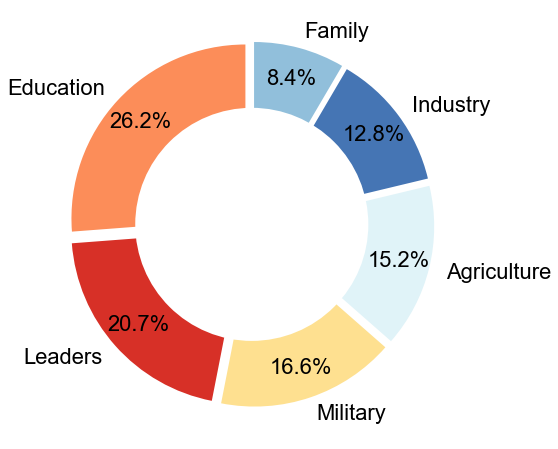

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)

colors_gender = ['#fc8d59','#d73027','#fee090','#e0f3f8','#4575b4','#91bfdb']
ax=topic_res['dominant_topic'].value_counts().plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_res.dominant_topic.unique())*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#### 2.2.2. Charting topic proportions (aggregated topic weights)

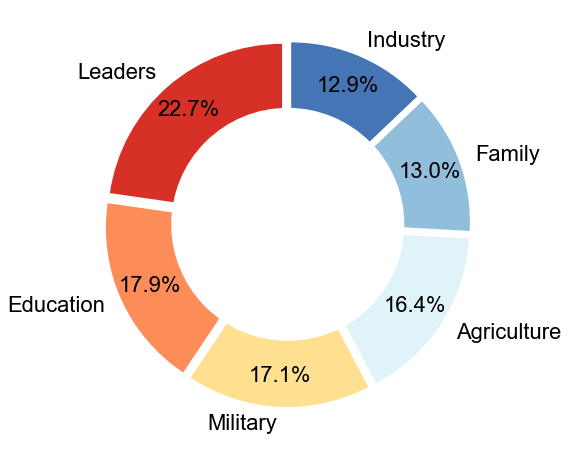

In [14]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)

colors_gender = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']
topic_columns = list(topic_res.columns)
topic_columns.pop(topic_columns.index('dominant_topic'))
#topic_columns.pop(topic_columns.index('year'))
ax=topic_res[topic_columns].sum().sort_values(ascending=False).plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [16]:
topic_res['year']=list(topic_res.index.str[:4])

## 3. Time series of topics

### 3.1. By topic weights

#### 3.1.1. Year to year evolution (topic weights)

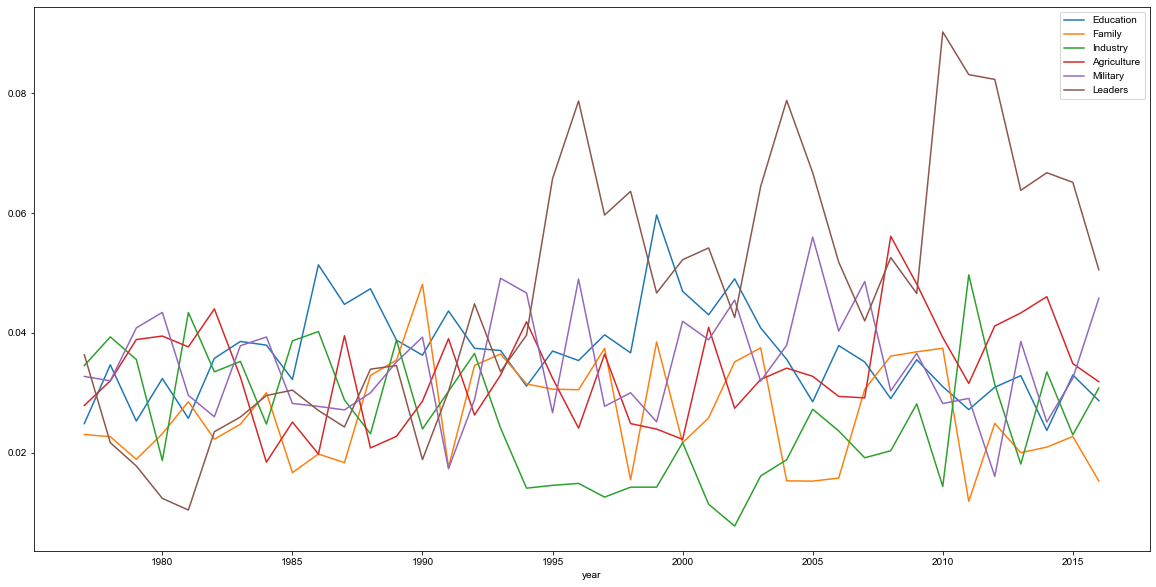

In [17]:
%matplotlib inline
topic_res['year'] = topic_res['year'].astype(int)
topic_res[['year'] + topic_columns].groupby('year').mean().plot(figsize=(20,10))

#### 3.1.2. 3-year moving average (topic weights)

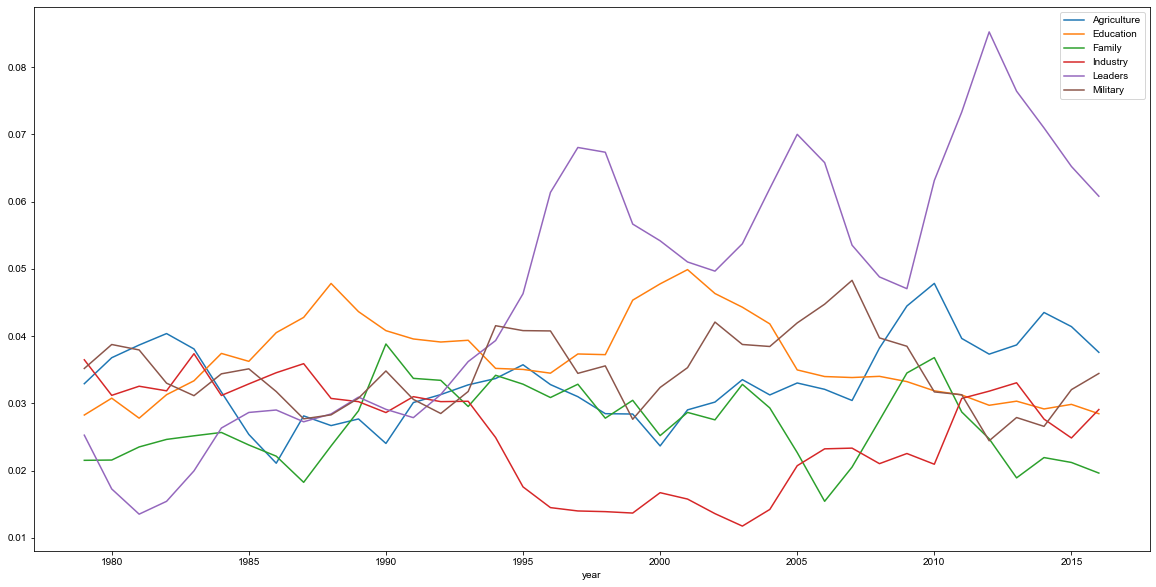

In [18]:
line_colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
dd = topic_res[['year'] + topic_columns].groupby('year').mean().rolling(window=3).mean()
dd = dd.reindex(sorted(dd.columns), axis=1)
ax = dd.plot(figsize=(20,10),x_compat=True, color=line_colors)
#plt.xticks(range(0,len(dd.index)), dd.index, rotation = 'vertical')
pass

#### 3.1.3. Correlation of topics with time (topic weights)

In [19]:
dd
x = list(range(1979, 2017))
import scipy

for col in dd.columns:
    print(col)
    print(scipy.stats.pearsonr(dd[col][dd.index > 1978], x))

Agriculture
(0.4282044046109563, 0.00731824674043428)
Education
(-0.18056506815029688, 0.2779912510432931)
Family
(-0.02932059180727449, 0.8612808697807871)
Industry
(-0.4220564628013528, 0.008304944916808756)
Leaders
(0.8859063435191603, 1.4466810146386416e-13)
Military
(0.034804655664650214, 0.8356616066383601)


### 3.2. By dominant topic

#### 3.2.1. 3 year moving average (dominant topic)

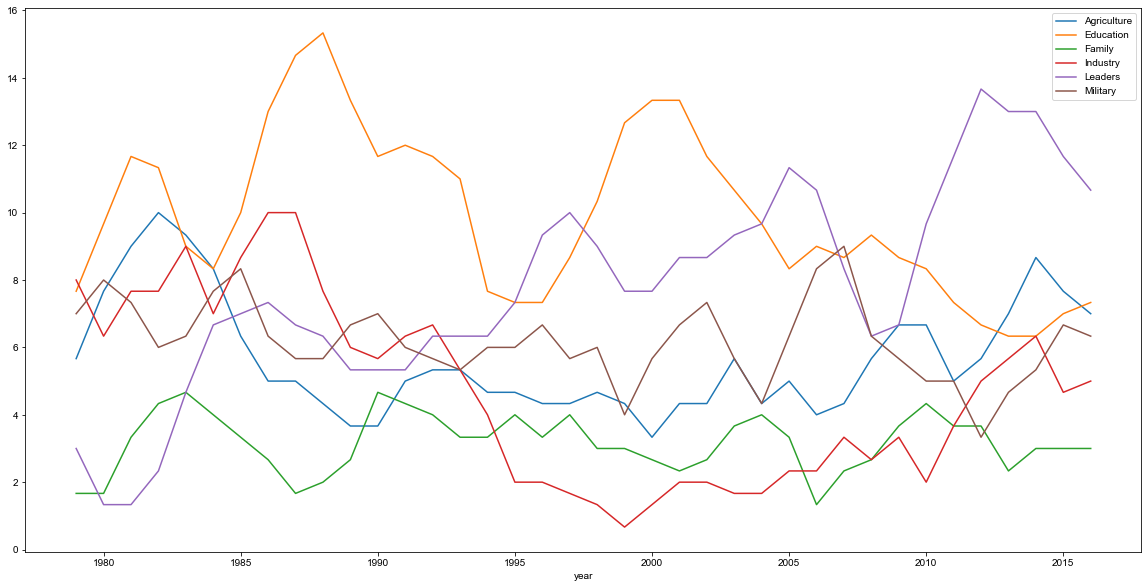

In [20]:
out = pd.pivot_table(topic_res[['dominant_topic']], index=topic_res.year, columns=topic_res.dominant_topic, aggfunc='count').fillna(0)
out.columns = out.columns.droplevel(0)
mva = out.rolling(window=3).mean()
mva.columns.name = None 
mva = mva.reindex(sorted(mva.columns), axis=1)
ax = mva.plot(figsize=(20,10),color=line_colors,x_compat=True)
#plt.xticks(range(0,len(mva.index)), mva.index, rotation = 'vertical')
pass

#### 3.2.2. Correlation with time (dominant topic)

In [21]:
for col in mva.columns:
    print(col)
    print(scipy.stats.pearsonr(mva[col][mva.index > 1978], x))

Agriculture
(-0.132524953456942, 0.42768669362307726)
Education
(-0.4897334459037542, 0.0018039161981721055)
Family
(-0.016725215630071094, 0.9206111617467543)
Industry
(-0.5901366420048126, 9.634144057461986e-05)
Leaders
(0.8501804057236672, 1.4357120542654555e-11)
Military
(-0.3559349485341589, 0.028291357964543306)


## 4. Thematic chunk analysis

We want to verify that the leaders are mostly talked about at the end of "Regular" novels. 
We will count the occurence of the names of the leaders in novels whose dominant theme is not the leaders.

In [22]:
def split_into_chunks(text, percentage = 0.1):
    chunks = {}
    i = 0
    end = 0
    while end < len(text):
        start = round(len(text) * ((percentage) * i))
        end = round(len(text) * ((percentage) * (i+1)))
        chunks[i+1] = text[start:end]
        i+=1
    return chunks

In [23]:
not_leaders = ori_df[topic_res['dominant_topic'] != 'Leaders']
not_leaders.columns = ['content', 'year']

In [24]:
deciles = pd.DataFrame(list(not_leaders.content.apply(lambda x: split_into_chunks(x))))

In [25]:
def count_leaders(text):
    return text.count('김일성') + text.count('김정일')+ text.count('김정은')

In [26]:
leader_counts = deciles.applymap(lambda x: count_leaders(x))

Text(0.5, 0, 'Narrative decile')

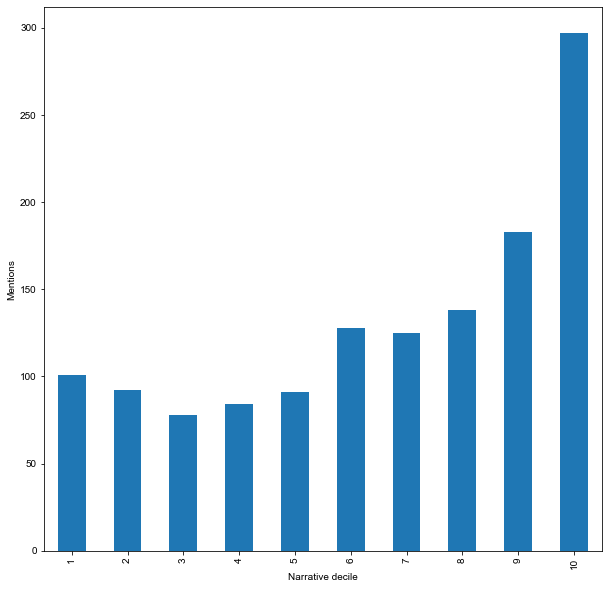

In [27]:
ax = deciles.applymap(lambda x: count_leaders(x)).sum().plot.bar(figsize=(10,10))
ax.set_ylabel("Mentions")
ax.set_xlabel("Narrative decile")

In [29]:
lead_distrib = deciles.applymap(lambda x: count_leaders(x)).sum().to_dict()

In [30]:
import scipy
scipy.stats.pearsonr(list(lead_distrib.keys()), list(lead_distrib.values()))

(0.7935574476953436, 0.006142231752179749)

## 5. Leader trends

In [31]:
leaders = pd.DataFrame([df[0].apply(lambda x: x.count('김정은')), df[0].apply(lambda x: x.count('김정일')), df[0].apply(lambda x: x.count('김일성'))]).transpose()
leaders.columns = ['Kim Jong-Un', 'Kim Jong-Il', 'Kim Il-Sung']
leaders['year']=list(leaders.index.str[:4])
leaders['year']=leaders['year'].astype(int)
leaders.reset_index(inplace=True, drop=True)

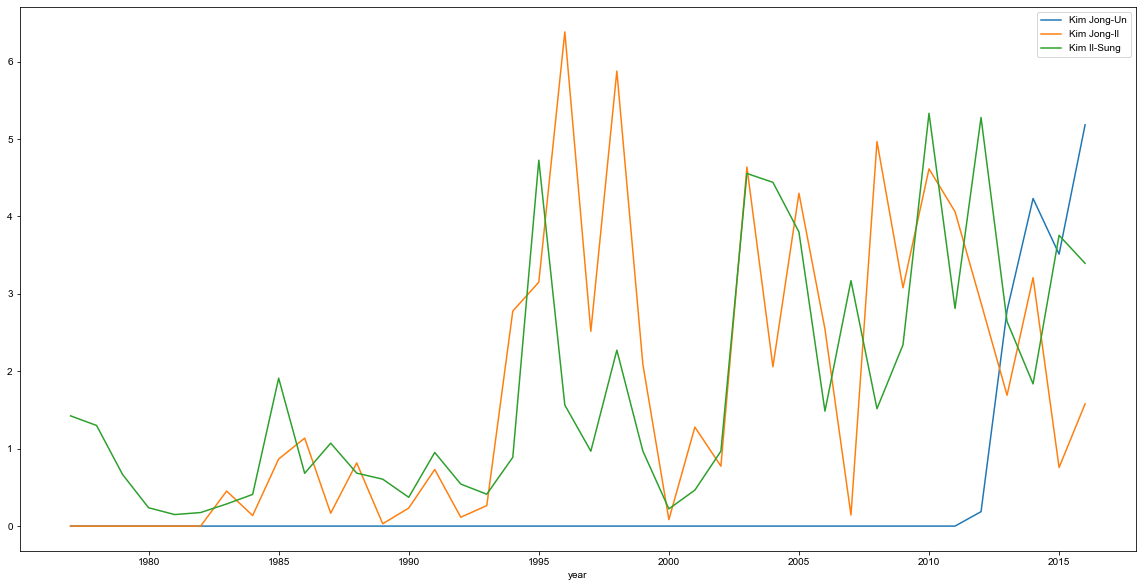

In [32]:
leaders.groupby('year').mean().plot(figsize=(20,10))

In [33]:
leaders.groupby('year').sum()

,Kim Jong-Un,Kim Jong-Il,Kim Il-Sung
year,,,
1977,0,0,47
1978,0,0,39
1979,0,0,24
1980,0,0,9
1981,0,0,7
1982,0,0,7
1983,0,19,12
1984,0,6,18
1985,0,39,86


## 6. Keyword trends

### 6.1. Foods

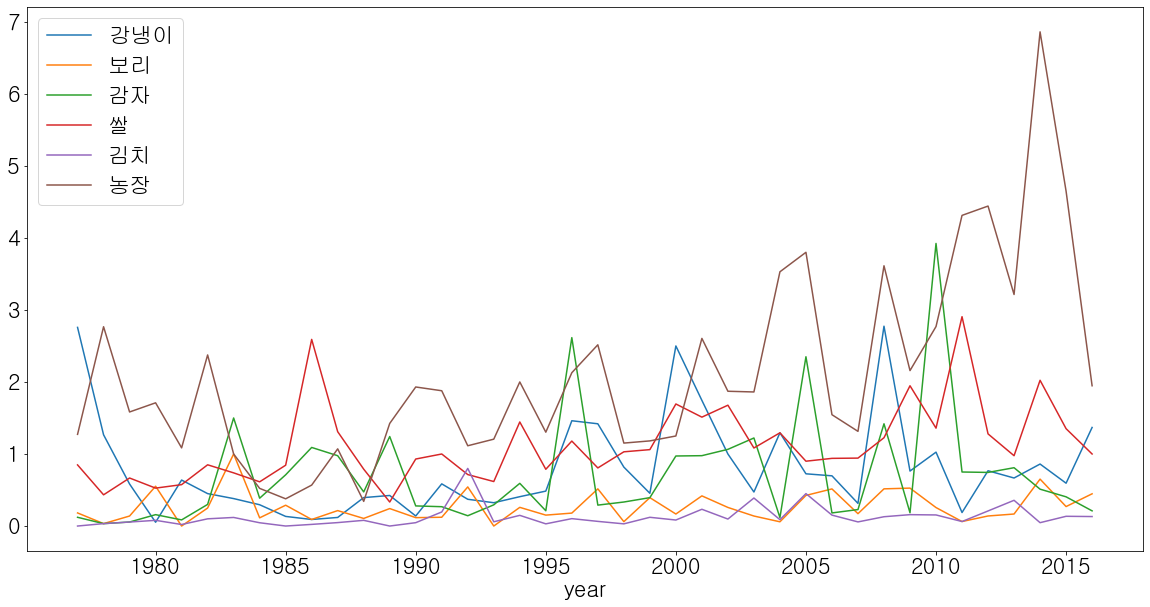

In [95]:
%matplotlib inline 

def create_count_df(keywords):
    counts = []
    for keyword in keywords:
        counts.append(ori_df[0].apply(lambda x: x.count(keyword)))
    
    counts = pd.DataFrame(counts).transpose()
    counts.columns = keywords
    counts['year']=list(counts.index.str[:4])
    counts['year']=counts['year'].astype(int)
    counts.reset_index(inplace=True, drop=True)
    return counts

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\gulim.ttc').get_name(), size=22)
keywords = ['강냉이', '보리', '감자', '쌀', '김치']

create_count_df(keywords).groupby('year').mean().plot(figsize=(20,10))

### 6.2. Nukes

C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44400 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44400 missing from current font.
  font.set_text(s, 0, flags=flags)


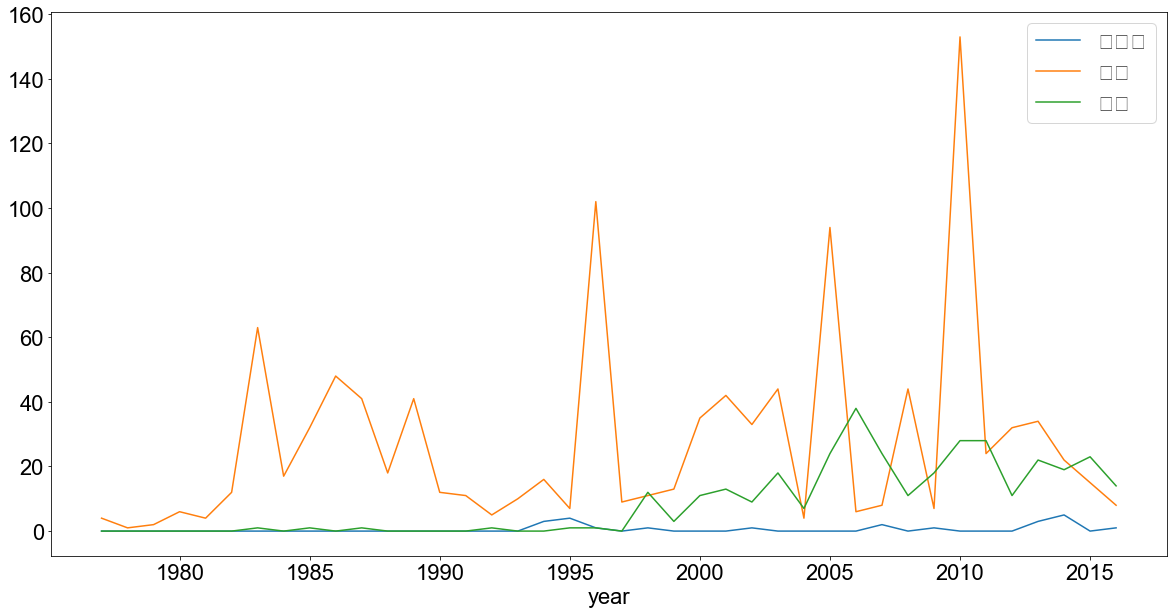

In [92]:
create_count_df(['핵무기', '감자', '선군']).groupby('year').sum().plot(figsize=(20,10))

In [160]:
preprocessed_texts = df.copy()
preprocessed_texts['year']=list(preprocessed_texts.index.str[:4])
preprocessed_texts['year']=preprocessed_texts['year'].astype(int)
preprocessed_texts.reset_index(inplace=True, drop=True)

In [162]:
preprocessed_texts[(preprocessed_texts['year'] == 1994) & preprocessed_texts[0].str.contains('핵')][0].apply(lambda x: x.count('핵'))

667     1
668    37
670     1
681     2
689     1
Name: 0, dtype: int64

### 6.3. Provinces

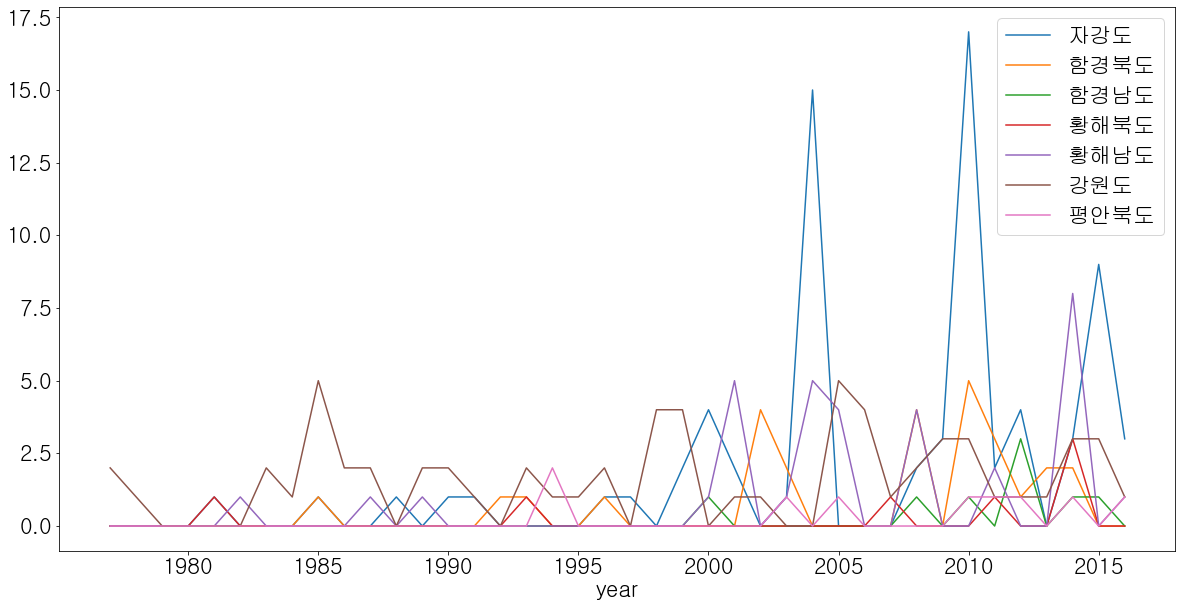

In [195]:
create_count_df(['자강도', '함경북도','함경남도', '황해북도','황해남도', '강원도', '평안북도']).groupby('year').sum().plot(figsize=(20,10))

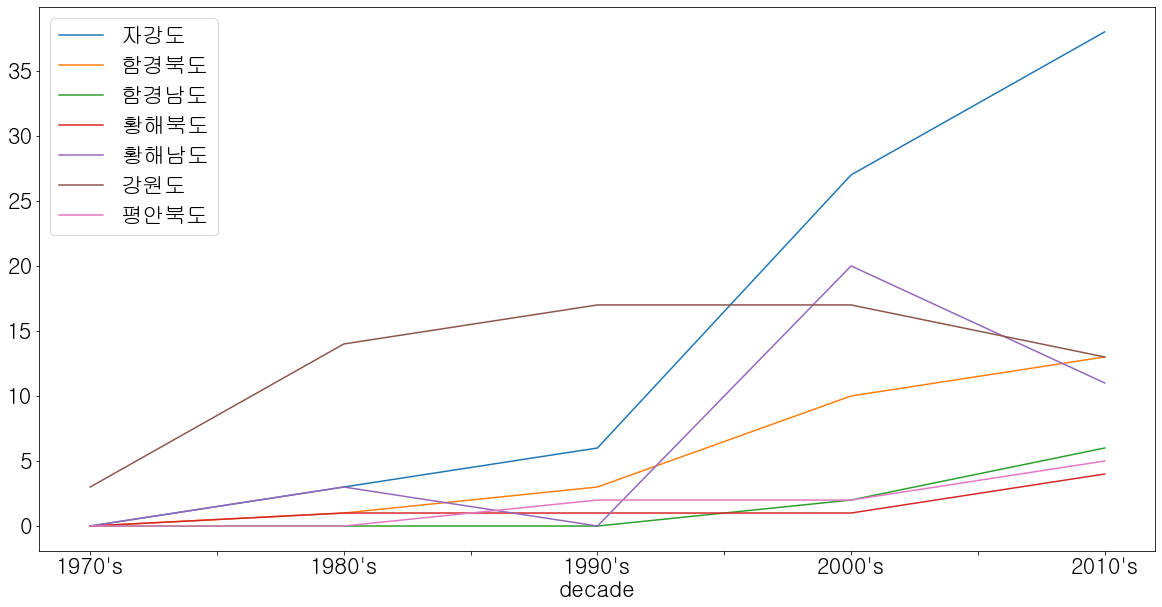

In [196]:
def make_decade(year):
    if 1990 > int(year) > 1979:
        return "1980's"
    if 2000 > int(year) > 1989:
        return "1990's"
    if 2010 > int(year) > 1999:
        return "2000's"
    if int(year) > 2000:
        return "2010's"
    else:
        return "1970's"
    
def create_count_df_by_decade(keywords):
    counts = []
    for keyword in keywords:
        counts.append(ori_df[0].apply(lambda x: x.count(keyword)))
    
    counts = pd.DataFrame(counts).transpose()
    counts.columns = keywords
    counts['year']=list(counts.index.str[:4])
    counts['year']=counts['year'].astype(int)
    counts['decade'] = counts['year'].apply(make_decade)
    counts.drop('year', inplace=True, axis=1)
    counts.reset_index(inplace=True, drop=True)
    return counts

create_count_df_by_decade(['자강도', '함경북도','함경남도', '황해북도','황해남도', '강원도', '평안북도']).groupby('decade').sum().plot(figsize=(20,10))